In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
%matplotlib inline
plt.style.use('ggplot')
inputs = tf.placeholder(tf.float32, [None, 120, 25], 'inputs')
targets = tf.placeholder(tf.float32, [None, 25], 'targets')


/afs/inf.ed.ac.uk/user/s17/s1773005/miniconda3/envs/mlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_error_and_accuracy(data):
    """Calculate average error and classification accuracy across a dataset.
    
    Args:
        data: Data provider which iterates over input-target batches in dataset.
        
    Returns:
        Tuple with first element scalar value corresponding to average error
        across all batches in dataset and second value corresponding to
        average classification accuracy across all batches in dataset.
    """
    err = 0
    acc = 0
    for input_batch, target_batch in data:
        err += sess.run(error, feed_dict={inputs: input_batch, targets: target_batch})
        acc += sess.run(accuracy, feed_dict={inputs: input_batch, targets: target_batch})
    err /= data.num_batches
    acc /= data.num_batches
    return err, acc

In [3]:
n_hidden_1 = 200
time_steps = 120
beta = 0.01 #0.009

input = tf.unstack(inputs ,time_steps,1)

weights = {
    'h1': tf.Variable(tf.random_normal([25, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, 25]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([25]))
}
def LSTM_1layer_200(data):
    lstm_layer = tf.nn.rnn_cell.LSTMCell(n_hidden_1,forget_bias=1.)
    LSTM_layer,_=rnn.static_rnn(lstm_layer,data,dtype="float32")
    
    out_layer = tf.matmul(LSTM_layer[-1], weights['out']) + biases['out']
    return out_layer
out_layer = LSTM_1layer_200(input)

per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=targets)
error = tf.reduce_mean(per_datapoint_errors)
#regularizer = tf.nn.l2_loss(weights['h1'])+tf.nn.l2_loss(weights['out'])
#error = tf.reduce_mean(error + beta * regularizer)

per_datapoint_pred_is_correct = tf.equal(tf.argmax(out_layer, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
sess.run(init_op)

import data_providers_rnn as data_providers_rnn
train_data = data_providers_rnn.MSD25GenreDataProvider('train', batch_size=50, flatten=True, one_hot=True)
valid_data = data_providers_rnn.MSD25GenreDataProvider('valid', batch_size=50, flatten=True, one_hot=True)

num_epoch = 50
error_train = []
error_valid = []
acc_train = []
acc_valid = []

for e in range(num_epoch):
    running_error = 0.
    running_acc = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_acc += batch_acc
    running_error /= train_data.num_batches
    running_acc /= train_data.num_batches
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error), 
          'running acc average = {1:.2f}'.format(e + 1, running_acc))
    error_train = np.append(error_train, running_error)
    acc_train = np.append(acc_train, running_acc)
    a = get_error_and_accuracy(valid_data)
    error_valid = np.append(error_valid, a[0])
    acc_valid = np.append(acc_valid, a[1])
    
LSTM_1layers_200_25 = [error_train, acc_train, error_valid, acc_valid]

End of epoch 1: running error average = 1.71 running acc average = 0.41
End of epoch 2: running error average = 1.44 running acc average = 0.49
End of epoch 3: running error average = 1.32 running acc average = 0.54
End of epoch 4: running error average = 1.22 running acc average = 0.57
End of epoch 5: running error average = 1.14 running acc average = 0.60
End of epoch 6: running error average = 1.06 running acc average = 0.63
End of epoch 7: running error average = 0.97 running acc average = 0.66
End of epoch 8: running error average = 0.90 running acc average = 0.69
End of epoch 9: running error average = 0.82 running acc average = 0.72
End of epoch 10: running error average = 0.76 running acc average = 0.74
End of epoch 11: running error average = 0.70 running acc average = 0.76
End of epoch 12: running error average = 0.61 running acc average = 0.79
End of epoch 13: running error average = 0.55 running acc average = 0.82
End of epoch 14: running error average = 0.48 running acc av

In [4]:
np.save('LSTM_1layers_200_25', LSTM_1layers_200_25)

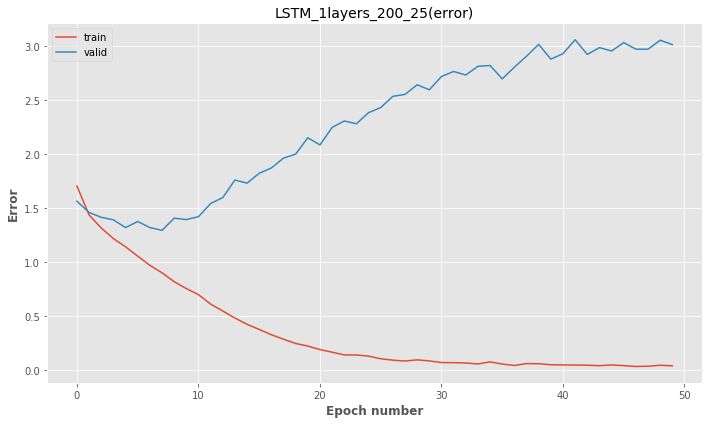

In [5]:
data = LSTM_1layers_200_25

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[0].shape[0]), data[0], label = 'train')
ax_1.plot(np.arange(data[2].shape[0]), data[2], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('Error', fontsize = 12, fontweight = 1000)
ax_1.set_title('LSTM_1layers_200_25(error)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('LSTM_1layers_200_25(error).pdf')

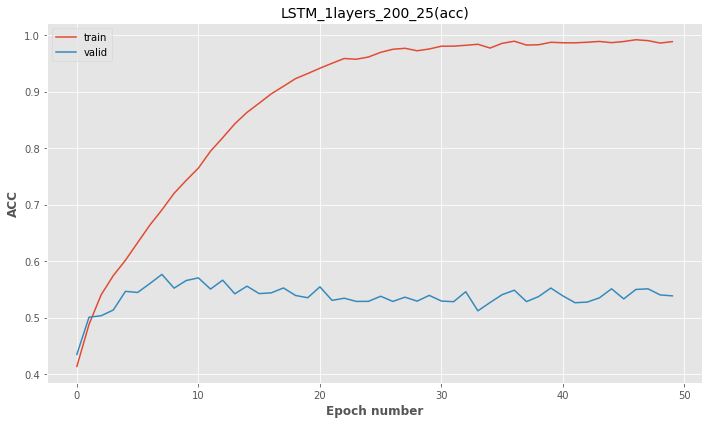

In [6]:
data = LSTM_1layers_200_25

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[1].shape[0]), data[1], label = 'train')
ax_1.plot(np.arange(data[3].shape[0]), data[3], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('ACC', fontsize = 12, fontweight = 1000)
ax_1.set_title('LSTM_1layers_200_25(acc)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('LSTM_1layers_200_25(acc).pdf')

In [3]:
n_hidden_1 = 200
time_steps = 120
beta = 0.01 #0.009

input = tf.unstack(inputs ,time_steps,1)

weights = {
    'h1': tf.Variable(tf.random_normal([25, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, 25]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([25]))
}
def LSTM_1layer_200(data):
    lstm_layer = tf.nn.rnn_cell.LSTMCell(n_hidden_1,forget_bias=1.)
    LSTM_layer,_=rnn.static_rnn(lstm_layer,data,dtype="float32")
    
    out_layer = tf.matmul(LSTM_layer[-1], weights['out']) + biases['out']
    return out_layer
out_layer = LSTM_1layer_200(input)

per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=targets)
error = tf.reduce_mean(per_datapoint_errors)
regularizer = tf.nn.l2_loss(weights['out'])
error = tf.reduce_mean(error + beta * regularizer)

per_datapoint_pred_is_correct = tf.equal(tf.argmax(out_layer, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
sess.run(init_op)

import data_providers_rnn as data_providers_rnn
train_data = data_providers_rnn.MSD25GenreDataProvider('train', batch_size=50, flatten=True, one_hot=True)
valid_data = data_providers_rnn.MSD25GenreDataProvider('valid', batch_size=50, flatten=True, one_hot=True)

num_epoch = 50
error_train = []
error_valid = []
acc_train = []
acc_valid = []

for e in range(num_epoch):
    running_error = 0.
    running_acc = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_acc += batch_acc
    running_error /= train_data.num_batches
    running_acc /= train_data.num_batches
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error), 
          'running acc average = {1:.2f}'.format(e + 1, running_acc))
    error_train = np.append(error_train, running_error)
    acc_train = np.append(acc_train, running_acc)
    a = get_error_and_accuracy(valid_data)
    error_valid = np.append(error_valid, a[0])
    acc_valid = np.append(acc_valid, a[1])
    
LSTM_1layers_200_25_l2 = [error_train, acc_train, error_valid, acc_valid]

End of epoch 1: running error average = 17.61 running acc average = 0.42
End of epoch 2: running error average = 7.30 running acc average = 0.49
End of epoch 3: running error average = 3.46 running acc average = 0.53
End of epoch 4: running error average = 2.02 running acc average = 0.57
End of epoch 5: running error average = 1.50 running acc average = 0.59
End of epoch 6: running error average = 1.29 running acc average = 0.61
End of epoch 7: running error average = 1.17 running acc average = 0.64
End of epoch 8: running error average = 1.11 running acc average = 0.65
End of epoch 9: running error average = 1.04 running acc average = 0.67
End of epoch 10: running error average = 0.99 running acc average = 0.69
End of epoch 11: running error average = 0.96 running acc average = 0.70
End of epoch 12: running error average = 0.91 running acc average = 0.72
End of epoch 13: running error average = 0.89 running acc average = 0.73
End of epoch 14: running error average = 0.84 running acc a

In [4]:
np.save('LSTM_1layers_200_25_l2', LSTM_1layers_200_25_l2)

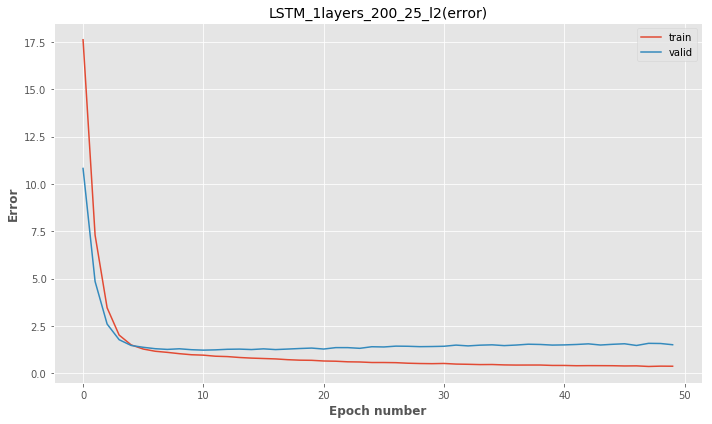

In [5]:
data = LSTM_1layers_200_25_l2

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[0].shape[0]), data[0], label = 'train')
ax_1.plot(np.arange(data[2].shape[0]), data[2], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('Error', fontsize = 12, fontweight = 1000)
ax_1.set_title('LSTM_1layers_200_25_l2(error)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('LSTM_1layers_200_25_l2(error).pdf')

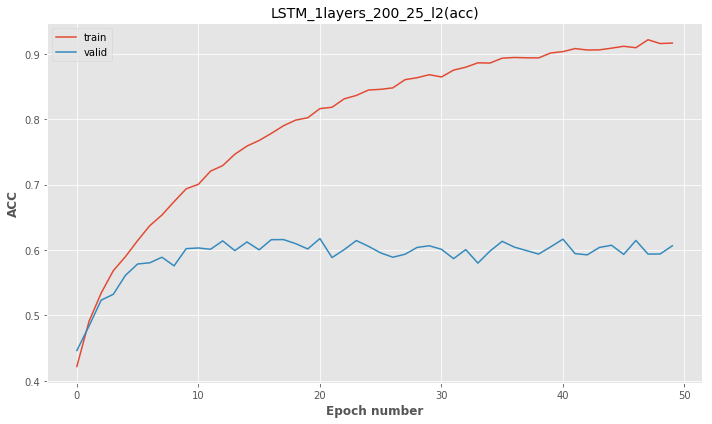

In [6]:
data = LSTM_1layers_200_25_l2

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[1].shape[0]), data[1], label = 'train')
ax_1.plot(np.arange(data[3].shape[0]), data[3], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('ACC', fontsize = 12, fontweight = 1000)
ax_1.set_title('LSTM_1layers_200_25_l2(acc)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('LSTM_1layers_200_25_l2(acc).pdf')